In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random
import cv2
import warnings
import math
from tabulate import tabulate

In [ ]:
# Functions
"""
1. load_mat
2. drawLinedrawing
3. computeOrientation
4. computeLength
5. computeCurvature
6. computeJunctions
7. computeContourProperties
8. drawJunctions
9. drawLinedrawingProperty
10. computeColorIndex
11. drawMATproperty
12. drawThisProperty
13. drawAllProperties
14. getOrientationStats
15. getLengthStats
16. getCurvatureStats
17. getHorizontalVerticalStats
18. getJunctionStats
19. getContourPropertiesStats
"""

In [2]:
# Load a .mat file as a dataframe named 'data'
def load_mat(filename):
    import scipy.io as sio
    mat = sio.loadmat(filename)
    return mat

filename='../dataSets/TorontoScenes/highways_vecLD.mat'

In [3]:
data = load_mat(filename)

In [4]:
# Get the keys of the dictionary

# originalImage, imsize, lineMethod, numContours, contours, 
# data['vecLD']

In [5]:
# Given the above keys, we access 77th row of the data
data_keys = {'originalImage','imsize', 'lineMethod', 'numContours',                
            'contours', 'orientations', 'lengths',   'contourLengths',             
            'curvatures', 'junctions', 'parallelism',  'parallelismMeans',           
            'parallelism_allX', 'parallelism_allY','parallelism_allScores', 
            'parallelismBins', 'parallelismHistograms', 'parallelismNormHistograms',  
            'parallelismSumHistogram', 'parallelismNormSumHistogram',
            'separation', 'separationMeans', 'separation_allX',  'separation_allY',            
            'separation_allScores', 'separationBins',             
            'separationHistograms', 'separationNormHistograms',   
            'separationSumHistogram', 'separationNormSumHistogram', 
            'mirror', 'mirrorMeans', 'mirror_allX', 'mirror_allY',                
            'mirror_allScores', 'mirrorBins', 'mirrorHistograms', 
            'mirrorNormHistograms', 'mirrorSumHistogram', 'mirrorNormSumHistogram'}

In [6]:
# How to view the data
# Choose row 77


print(data['vecLD']['contourLengths'][0][0][76])
print(data['vecLD']['contours'][0][8].shape)
print(data['vecLD']['contourLengths'][0][1].shape)

[26.06099729]
(1, 296)
(490, 1)


In [7]:
cute = {}
# Assign the data to the dictionary and define them with empty value
for key in data_keys:
    cute[key] = data['vecLD'][key][0][76]
print(cute['contours'][0].shape)

(191,)


In [8]:
def drawLinedrawing(vecLD,
                    lineWidth=1,
                    color = [0,0,0]):
    fig, ax = plt.subplots()
    for i in range(vecLD['numContours'][0][0]):
        thisC = vecLD['contours'][0][i]
        # print("Shape of thisC: ", thisC.shape)
        # print(thisC)
        X_1 = thisC[:,0]
        Y_1 = thisC[:,1]
        X_2 = thisC[-1:,2]
        Y_2 = thisC[-1:,3]
        # print(X_1, Y_1, X_2, Y_2)
        # print("Shape of X_1: ", X_1.shape)
        # print("Shape of Y_1: ", Y_1.shape)
        # print("Shape of X_2: ", X_2.shape)
        # print("Shape of Y_2: ", Y_2.shape)
        X = np.concatenate((X_1, X_2))
        Y = np.concatenate((Y_1, Y_2))
        # X = [thisC[0,:], thisC[2,-1]]
        # Y = [thisC[1,:], thisC[3,-1]]
        ax.plot(X, Y,'-' , color=color, linewidth=lineWidth)

    ax.set_aspect('equal')
    ax.set_xlim([0, vecLD['imsize'][0][0]])
    ax.set_ylim([0, vecLD['imsize'][0][1]])
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  
    plt.title('Original - '+vecLD['originalImage'][0])

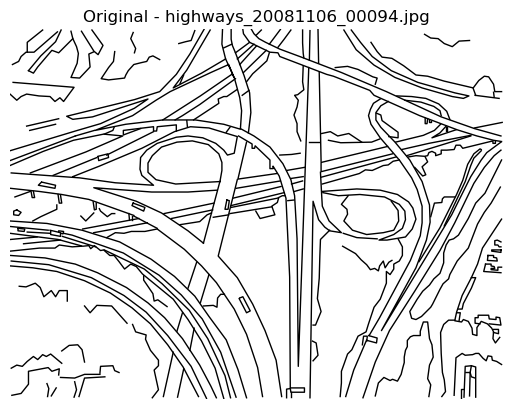

In [9]:
drawLinedrawing(cute)

### Rest of the functions

In [10]:
def computeOrientation(vecLD):
    vecLD['orientations'] = []
    for c in range(vecLD['numContours'][0][0]):
        thisCon = vecLD['contours'][0][c]
        ori = np.mod(np.degrees(np.arctan2(thisCon[:,1].astype(np.int32) - thisCon[:,3].astype(np.int32), 
                                           thisCon[:,2].astype(np.int32) - thisCon[:,0].astype(np.int32))), 360)
        vecLD['orientations'].append(ori)
    return vecLD

In [11]:
def computeLength(vecLD):
    """
    Computes the length for the contours in the vectorized line drawing vecLD.

    Args:
        vecLD (LineDrawingStructure): The vectorized line drawing data structure.

    Returns:
        LineDrawingStructure: A vector LD of structs with length information added.

    -----------------------------------------------------
    This function is part of the Mid Level Vision Toolbox:
    http://www.mlvtoolbox.org

    Copyright (c) 2022 Dirk Bernhardt-Walther
    University of Toronto, Toronto, Ontario, Canada

    Contact: dirk.walther@gmail.com
    -----------------------------------------------------
    """
    vecLD['lengths'] = []
    vecLD['contourLengths'] = []
    for c in range(vecLD['numContours'][0][0]):
        thisCon = vecLD['contours'][0][c]
        val = np.sqrt(np.sqrt(thisCon[:,2]-thisCon[:,0])+ np.sqrt(thisCon[:,3]-thisCon[:,1]))
        vecLD['lengths'].append(val)
        vecLD['contourLengths'].append(np.sum(val)) # Need to verify this
    return vecLD

In [12]:
def computeCurvature(vecLD):
    """
    Computes curvature for the contours in the vectorized line drawing vecLD.

    Args:
        vecLD (LineDrawingStructure): The vectorized line drawing data structure.

    Returns:
        LineDrawingStructure: A vector LD of structs with curvature information added.

    -----------------------------------------------------
    This function is part of the Mid Level Vision Toolbox:
    http://www.mlvtoolbox.org

    Copyright Dirk Bernhardt-Walther
    University of Toronto, Toronto, Ontario, Canada, 2022

    Contact: dirk.walther@gmail.com
    -----------------------------------------------------
    """
    if not hasattr(vecLD, 'orientations'):
        vecLD = computeOrientation(vecLD)
    # if not hasattr(vecLD, 'lengths'):
    #     print('Computing contour lengths')
    #     vecLD = computeLength(vecLD)
    
    vecLD['curvatures'] = []
    for c in range(vecLD['numContours'][0][0]):
        thisCon = vecLD['contours'][0][c]
        numSegments = thisCon.shape[0]
        vecLD['curvatures'].append([])
        if numSegments == 1:
            vecLD['curvatures'].pop()
            vecLD['curvatures'].append(0) # Special case of only one straight segment
            continue
        for s in range(numSegments):
            if s == numSegments-1:
                s2 = s - 1 # for the last segment, we refer to the previous segment
            else:
                s2 = s + 1 # for all other segments, we refer to the next segment   
            angleDiff = np.abs(vecLD['orientations'][c][s] - vecLD['orientations'][c][s2])
            if angleDiff > 180:
                angleDiff = 360 - angleDiff # For angles > 180, we take the opposite angle
            vecLD['curvatures'][c].append(angleDiff / vecLD['lengths'][0][c][s])


    return vecLD

In [13]:
# To be worked on
def computeJunctions(vecLD):
    """
    Computes all junctions between contours in the vectorized line drawing vecLD.

    Args:
        vecLD (LineDrawingStructure): The vectorized line drawing data structure.

    Returns:
        LineDrawingStructure: A vector LD of structs with junction information added.

    Output Structure:
        Each junction consists of the following information:
        - contourIDs (list): Vector of IDs of contours involved in the junction.
        - segmentIDs (list): Vector of IDs of the segments within these contours.
        - position (list): Location of the junction [x, y].
        - angle (float): Smallest angle of the junction.
        - type (str): Based on the largest angle a, one of: 'T', 'Y', 'X', 'Arrow', 'Star'.

    -----------------------------------------------------
    This function is part of the Mid Level Vision Toolbox:
    http://www.mlvtoolbox.org

    Copyright Dirk Bernhardt-Walther
    University of Toronto, Toronto, Ontario, Canada, 2022

    Contact: dirk.walther@gmail.com
    -----------------------------------------------------
    """
    if not hasattr(vecLD, 'orientations'):
        vecLD = computeOrientation(vecLD)
    if not hasattr(vecLD, 'lengths'):
        vecLD = computeLength(vecLD)
    
    # 3 Step Process

    # 1. Detect any intersections between line segments
    jcts = detectIntersections(vecLD) # Need to write this function

    # 2. Merge Junctions that the close by
    jcts = cleanupJunctions(jcts) # Need to write this function

    # 3. Measure angles and classify junctions
    vecLD['junctions'] = computeJunctionAnglesTypes(jcts, vecLD)    # Need to write this function

    return vecLD


### computeContourProperties function

In [14]:
def computeContourProperties(vecLD, 
                             whichProps=['orientation', 'length', 
                                         'curvature', 'junctions']):
    if not isinstance(whichProps, (list, tuple)):
        whichProps = [whichProps]
    for prop in range(len(whichProps)):
        thisProp = whichProps[prop].lower()
        if thisProp == 'orientation':
            vecLD = computeOrientation(vecLD)
        elif thisProp == 'length':
            vecLD = computeLength(vecLD) # Need to write code for this
        elif thisProp == 'curvature':
            vecLD = computeCurvature(vecLD) # Need to write code for this
        elif thisProp == 'junctions':
            vecLD = computeJunctions(vecLD) # Need to write code for this
        else:
            raise ValueError('Unknown property: ' + thisProp)
    return vecLD

### Draw functions

In [15]:
def drawJunctions(Junctions,
                  types = ['T', 'Y', 'X', 'Arrow', 'Star'],
                  MarkerSize = 10,
                  colors = None):
# Need to edit and verify this function
    if not isinstance(types, (list, tuple)):
        types = [types]
    
    # Special case of a vectorized line drawing
    if 'contours' in Junctions.dtype.names:
        drawLinedrawing(Junctions)
        Junctions = Junctions['junctions']
    
    if len(Junctions[0]) == 0:
        warnings.warn('No junctions to plot.')

    junctionTypes = [j['type'] for j in Junctions]
    
    # uniqueJunctionTypes = list(set(junctionTypes))
    # typeOccurs = np.isin(junctionTypes, types)
    types = np.unique(junctionTypes)

    if colors is None:
        # colors = plt.get_cmap('hsv')(np.linspace(0, 1, len(types)))
        default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [default_colors[i % len(default_colors)] for i in range(len(types))]

    
    # print(Junctions.shape)
    # print(len)
    positions = np.array([j['position'] for j in Junctions[0]]).reshape(-1,2)
    # print(positions.shape)
    h = []
    for t in range(len(types)):
        typeIdx = [types[t] == junction_type for junction_type in junctionTypes]
        # print("VAL:")
        # Get all the true values
        trueIdx = np.where(typeIdx)
        # print(trueIdx[1])
        # print(positions[trueIdx[1]])
        Idx = positions[trueIdx[1]]
        # print(Idx[:,0])
        # print("\n")
        # print(Idx[:,1])
        # print(len(Idx))
        # print("\n")
        # print(colors[t]*len(Idx)) 
        # Given [ 0.   0.   9.5 19. ], repeat [[ 0.   0.   9.5 19. ],[ 0.   0.   9.5 19. ]] so on len(Idx) times 
        color_Idx = np.repeat([colors[t]], len(Idx), axis=0)
        # print(len(color_Idx))
        # print(color_Idx)
        # print([colors[t]] * sum(typeIdx))
        plot = plt.scatter(Idx[:,0], Idx[:,1],
                            c=color_Idx,  # Repeat the color for each matching position
                            s=MarkerSize*2,
                            marker='o',
                            edgecolors=colors[t],
                            alpha=1.0)
        h.append(plot)

    # Put a legend to the right of the current axis
    plt.legend(h,types,loc='center left', bbox_to_anchor=(1, 1))
    plt.title('Junctions')


    # plt.legend(h, types)
    plt.gca().get_legend().set_visible(True)

    plt.show()

In [16]:
def drawLinedrawingProperty(vecLD,
                            property,
                            lineWidth=1):
    property = property.lower()
    # Junctions are treated differently
    if property in ['junctions']:
        drawLinedrawing(vecLD, lineWidth, [0, 0, 0])
        drawJunctions(vecLD['junctions'])
        return 
    
    # Get the color index
    colorIdx, cmap = computeColorIndex(vecLD, property)
    for i in range(len(colorIdx)):
        colorIdx[i] = colorIdx[i].astype(np.int64)
    # Draw the line segments one at a time
    fig, ax = plt.subplots()
    for i in range(vecLD['numContours'][0][0]):
        thisC = vecLD['contours'][0][i]
        for s in range(len(thisC)):
            X = [thisC[s,0], thisC[s,2]]
            Y = [thisC[s,1], thisC[s,3]]
            ax.plot(X, Y,'-' , color=cmap(colorIdx[i][s]), linewidth=lineWidth)

    ax.tick_params(axis='both', which='both', length=0)
    sm = plt.cm.ScalarMappable(cmap=cmap)  # Create the ScalarMappable object
    cbar = plt.colorbar(sm, ax=ax)  # Assign the colorbar to the same axes


    if property == 'length':
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['short','long'])
    elif property == 'curvature':
        cbar.set_ticks([0,1])
        cbar.set_ticklabels(['straight','angular'])
    elif property == 'orientation':
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(['horizontal', 'vertical', 'horizontal'])
    else:
        warnings.warn('Unknown Property: ' + property)
        return
    # ax.invert_xaxis()
    # Set axis limits
    ax.set_xlim([0, vecLD['imsize'][0][0]])
    ax.set_ylim([0, vecLD['imsize'][0][1]])
    ax.invert_yaxis()
    # Title 
    ax.set_title(property)
    # return fig, ax
    plt.show()

In [17]:
# def drawLineDrawing(vecLD,
#                     lineWidth=1,
#                     color = [0,0,0]):
#     fig, ax = plt.subplots()
#     for i in range(vecLD['numContours'][0][0]):
#         thisC = vecLD['contours'][0][i]
#         if i ==0:
#             print(thisC)
#             print(thisC.shape)
#             print("\n\n")
#         X = []
#         Y = []
#         for j in range(len(thisC[:,0])):
#             X.append(thisC[j][0])
#             Y.append(thisC[j][1])
#         X. append(thisC[-1,2])
#         Y.append(thisC[-1,3])
#         if i == 0:
#             print(X)
#             print("\n\n")
#             print(Y)
#         ax.plot(X, Y,'-' ,linewidth=lineWidth)

#     ax.set_aspect('equal')
#     ax.set_xlim([0, vecLD['imsize'][0][0]])
#     ax.set_ylim([0, vecLD['imsize'][0][1]])
#     ax.invert_yaxis()
#     ax.axis('off')  
#     plt.show()

### Compute Color Index

In [18]:
def computeColorIndex(vecLD, property):
    property = property.lower()
    colorIdx = []
    numCols = 256

    if property == 'length':
        # Log 10 of the length
        allLengths = np.log10(vecLD['contourLengths']+1)
        minProp = np.min(allLengths)
        maxProp = np.max(allLengths)
        col = np.round((allLengths - minProp) / (maxProp - minProp) * (numCols - 1) + 1).astype(int)
        for c in range(vecLD['numContours'][0][0]):
            colorIdx.append(np.zeros(len(vecLD['contours'][0][c])) + col[c])
        cmap = plt.get_cmap('jet', numCols)
    elif property == 'curvature':
        allCurv = []
        rowCurv = []
        for i in range(len(vecLD['curvatures'])):
            val1  = np.squeeze(vecLD['curvatures'][i]).astype(float)
            # print(val1)
            # Check if 0-d array
            if val1.ndim == 0:
                allCurv.append(0.0)
                rowCurv.append(np.array([0.0]))
            else:
                for j in val1:
                    allCurv.append(j)
                rowCurv.append(val1)
        allCurv = np.log10(np.array(allCurv)+1)
        maxProp = np.max(allCurv)*0.8 # Here we're fudging the range a little so that high curvatures are emphasized more
        minProp = np.min(allCurv)
        max_min = maxProp - minProp
        for i in range(vecLD['numContours'][0][0]):
            colorIdx.append(np.minimum(np.round((np.log10(rowCurv[i]+1)-minProp)/max_min*(255)+1),256))
        cmap = plt.get_cmap('jet', numCols)
    elif property == 'orientation':
        colorIdx = []
        for c in range(vecLD['numContours'][0][0]):
            colorIdx.append(np.round(np.mod(vecLD['orientations'][c], 180) / 180 * (numCols - 1) + 1))
        cmap = plt.get_cmap('hsv', numCols)
    else:
        warnings.warn('Unknown property: ' + property)
        colorIdx = []
        cmap = []
    return colorIdx, cmap

In [19]:
def drawMATproperty(vecLD,
                    property,
                    markerSize=1):
    property = property.lower()
    print(property)
    # Temp 

    # if not hasattr(vecLD, property+'_allX'):
    #     warnings.warn(f'Property {property} has not been computed')
    #     return
    
    # drawLinedrawing(vecLD)
    figureSize = [12, 12]
    fig, ax = plt.subplots(figsize=figureSize)
    ax.scatter(vecLD[property + '_allX'], vecLD[property + '_allY'], 
                s=markerSize, c=vecLD[property + '_allScores'], 
                cmap='jet')
    

    # Set axis properties
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='jet')  # Create the ScalarMappable object
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['lowest', 'intermediate', 'highest'])
    plt.title(property)

    plt.show()


In [20]:
def drawThisProperty(vecLD, property):
    property = property.lower()
    if property == 'original':
        drawLinedrawing(vecLD)
    elif property in ['length', 'orientation', 'curvature', 'junctions']:
        drawLinedrawingProperty(vecLD, property)
    elif property in ['parallelism', 'separation', 'mirror']:
        drawMATproperty(vecLD, property)
    else:
        warnings.warn('Unknown property: ' + property)
        return
    return

In [21]:
def drawAllProperties(vecLD, mode='subplot', properties=['Original','Length',
                                               'Orientation','Curvature',
                                               'Junctions','Mirror',
                                               'Parallelism','Separation']):
    if not isinstance(properties, list):
        properties = [properties]
    numProps = len(properties)

    # Switch statement for the mode
    if mode == 'subplot':
        # ceil(sqrt(numProps))
        m = math.ceil(math.sqrt(numProps))
        n = math.ceil(numProps / m)
        # Define a figure
        # figIDs, ax = plt.subplots(m, n)
        for p in range(numProps):
            # plt.subplot(m, n, p+1)
            drawThisProperty(vecLD, properties[p])
    elif mode == 'separate':
        figIDs = []
        for p in range(numProps):
            figIDs.append(plt.figure())
            drawThisProperty(vecLD, properties[p])
    else:
        warnings.warn('Unknown mode: ' + mode)

### Debug

In [22]:
temp_ld = computeContourProperties(cute, ['orientation', 'curvature'])

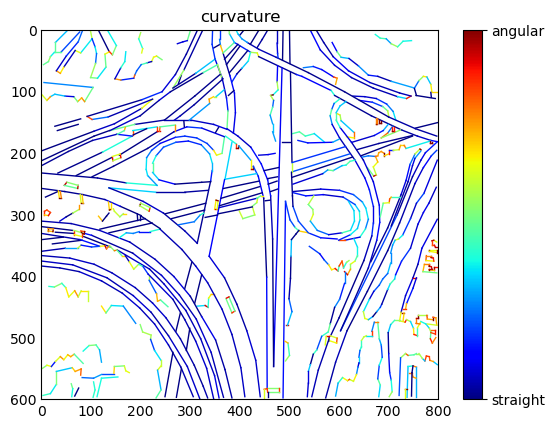

In [23]:
drawAllProperties(cute, 'subplot', ['curvature'])

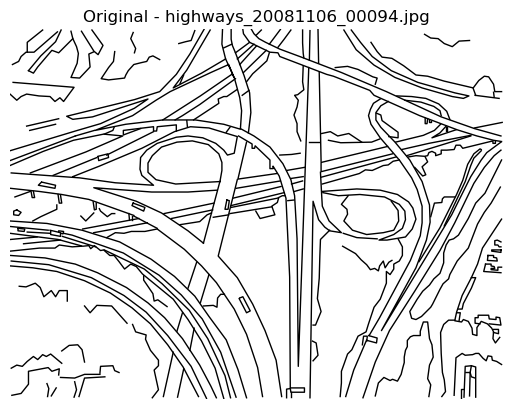

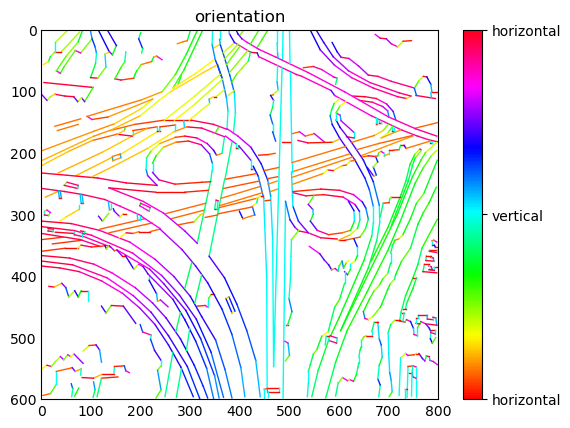

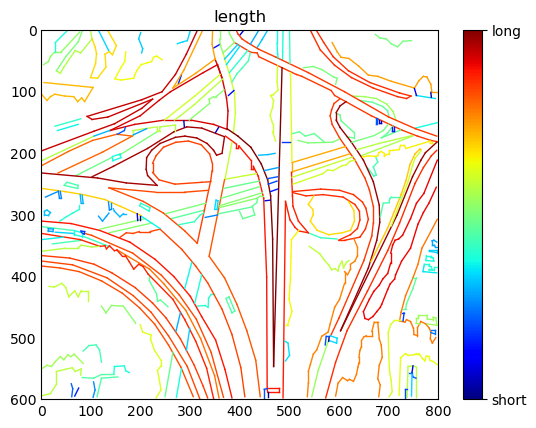

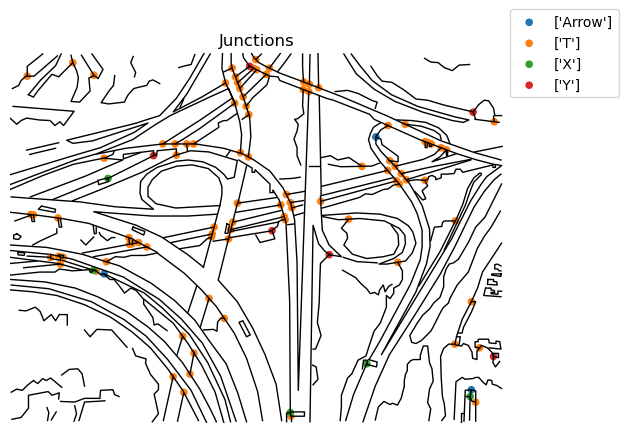

mirror


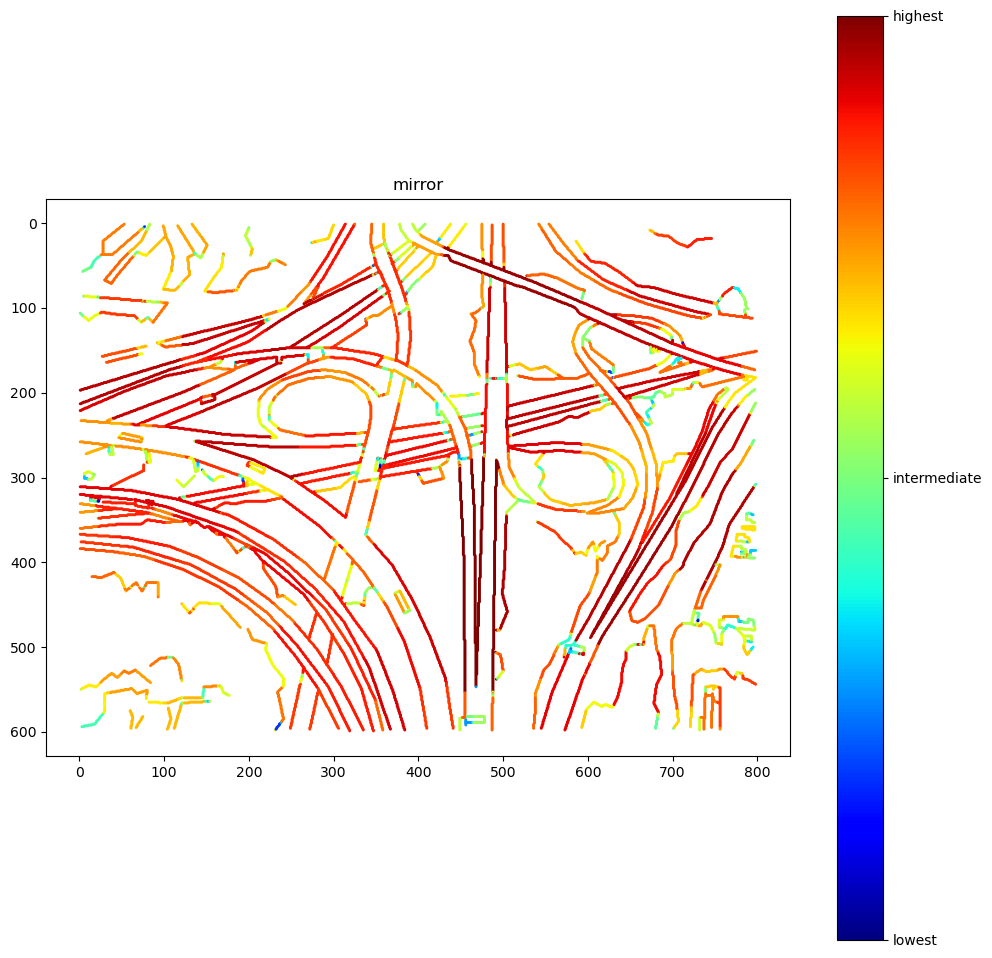

parallelism


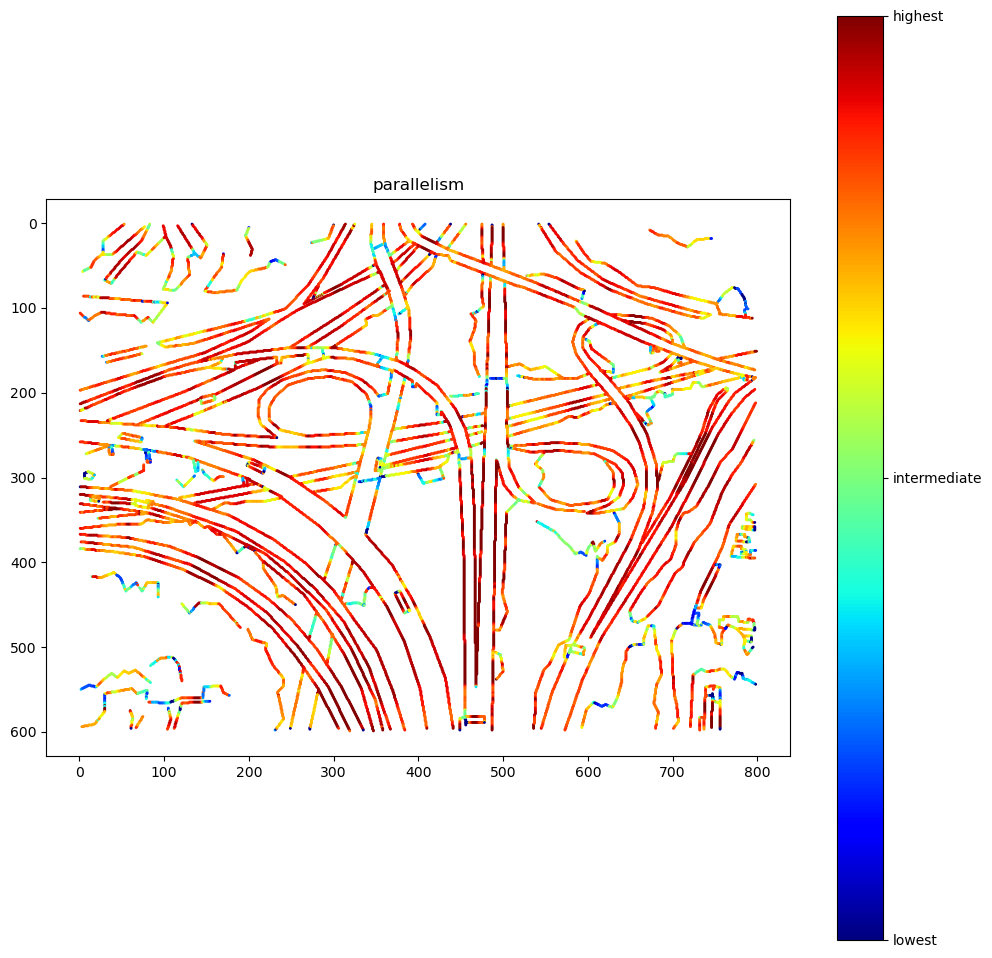

separation


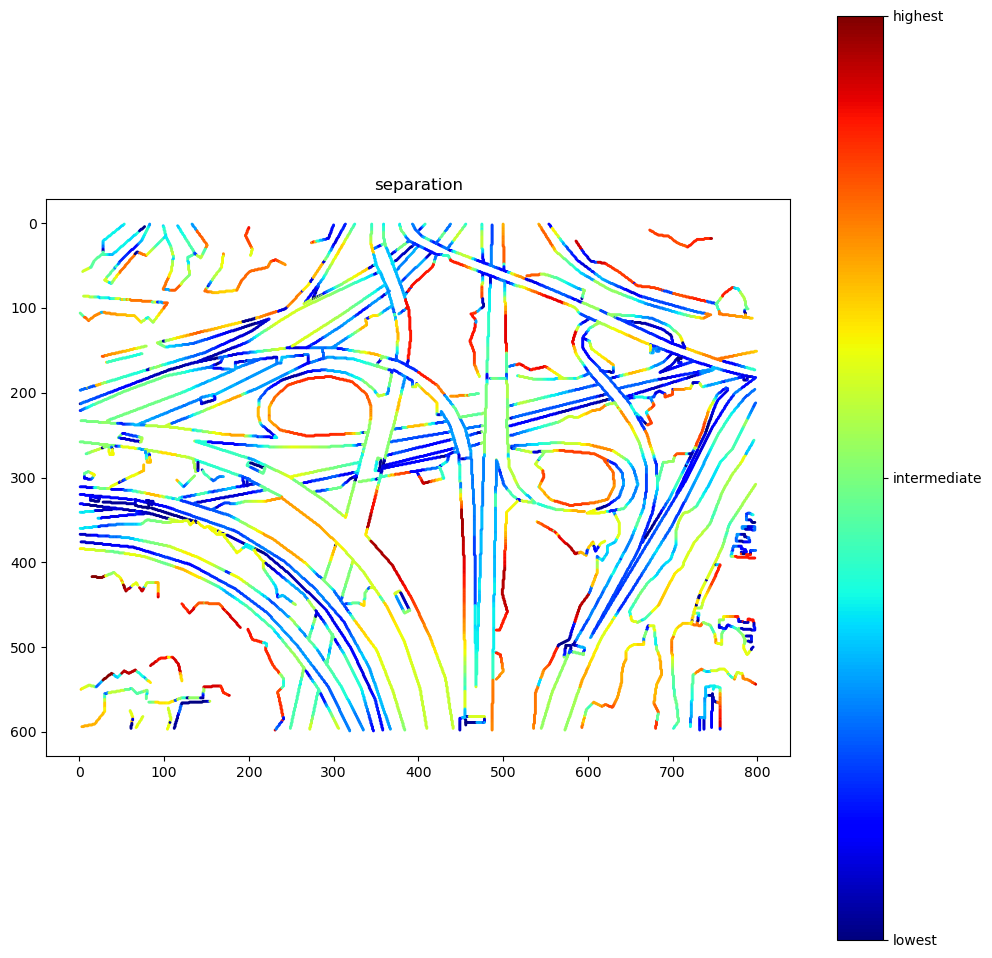

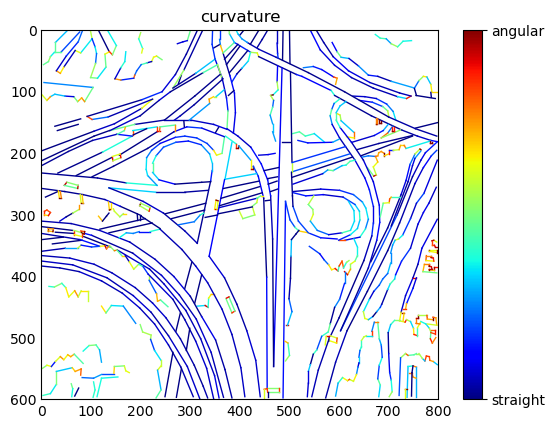

In [24]:
drawAllProperties(cute, 'subplot', ['original','orientation','length','junctions',
                                    'mirror','parallelism','separation', 'curvature'])

# Stats part

In [25]:
# Get a copy of cute 
temp_cute = cute.copy()

### Rest

In [26]:
def getOrientationStats(vecLD, numBins=8):
    # Check if vecLD's orientation key exists
    if 'orientations' not in vecLD:
        vecLD = computeOrientation(vecLD)
    if 'lengths' not in vecLD:
        vecLD = computeLength(vecLD)


    bwidth = 180/numBins
    bins = np.arange(0, 180, bwidth)
    binEdges = bins + bwidth/2
    # vecLD['orientationHistograms'] = np.zeros((vecLD['numContours'][0][0], numBins))
    # vecLD['normOrientstionHistograms'] = np.zeros((vecLD['numContours'][0][0], numBins))
    vecLD['orientationHistograms'] = np.full((vecLD['numContours'][0][0], numBins), np.nan)
    vecLD['normOrientstionHistograms'] = np.full((vecLD['numContours'][0][0], numBins), np.nan)
    for c in range(vecLD['numContours'][0][0]):
        thisHist = np.zeros(numBins)
        thisCon = vecLD['contours'][0][c]
        numSegments = thisCon.shape[0]
        # if c==0:
        #     print("thisCon: ", thisCon)

        for s in range(numSegments):
            this_ori = (vecLD['orientations'][c][s] + bwidth / 2) % 180 - bwidth / 2
            # if c == 0 and s == 0:
            #     print("this_ori: ", this_ori)
            # print(c, s, thisOri)
            for b in range(numBins):
                # print(this_ori, binEdges[b])
                if this_ori < binEdges[b]: 
                    # if c==0:
                    #     print("size of thisHist: ", thisHist[b], b)
                    #     print("size of vecLD['lengths'][c][s]: ", vecLD['lengths'][c][s].shape,  vecLD['lengths'][c][s])
                    #     print(b, c ,s)
                    # print(vecLD['lengths'][c][s], thisHist[b],sep="\n")
                    thisHist[b] = thisHist[b] + vecLD['lengths'][0][c][s]
                    # print("C: ",c, "S: ", s, "B: ", b)
                    break
        # print(thisHist)
        # if c == 0:
        #     print(thisHist)

        vecLD['orientationHistograms'][c,:] = thisHist
        vecLD['normOrientstionHistograms'][c,:] = vecLD['orientationHistograms'][c,:] / vecLD['contourLengths'][c] * 10000

    vecLD['sumOrientationHistogram'] = np.sum(vecLD['orientationHistograms'], axis=0)
    vecLD['normSumOrientationHistogram'] = vecLD['sumOrientationHistogram'] / np.sum(vecLD['contourLengths']) * 10000
    oriHistogram = vecLD['sumOrientationHistogram']
    vecLD['orientationBins'] = bins
    shortName = 'ori'
    return vecLD, oriHistogram, bins, shortName

In [27]:
def getLengthStats(vecLD,
                   numBins=8,
                   minmaxLength=None):
    if 'lengths' not in vecLD:
        vecLD = computeLength(vecLD)

    if minmaxLength is None:
        minmaxLength = [2, np.sum(vecLD['imsize'])]

        
    logMinMax = np.log10(np.array(minmaxLength)+1)
    binWidth = (logMinMax[1]-logMinMax[0])/numBins # the range of the original length is from max to min length value
    binBoundary = np.arange(logMinMax[0], logMinMax[1]+binWidth, binWidth) # Verify this
    bins = 10 ** (binBoundary[1:]-binWidth/2) - 1
    logLengths = np.log10(vecLD['contourLengths']+1)

    vecLD['lengthHistogram'] = np.full((vecLD['numContours'][0][0], numBins), np.nan)
    vecLD['normLengthHistogram'] = np.full((vecLD['numContours'][0][0], numBins), np.nan)
    for c in range(vecLD['numContours'][0][0]):
        thisHist = np.zeros(numBins)
        for b in range(numBins):
            if logLengths[c] < binBoundary[b+1] or (b == numBins-1):
                thisHist[b] = thisHist[b] + vecLD['contourLengths'][c]
                break
            
        vecLD['lengthHistogram'][c,:] = thisHist
        vecLD['normLengthHistogram'][c,:] = thisHist / vecLD['contourLengths'][c] * 10000
    
    vecLD['sumLengthHistogram'] = np.sum(vecLD['lengthHistogram'], axis=0)
    vecLD['normSumLengthHistogram'] = vecLD['sumLengthHistogram'] / np.sum(vecLD['contourLengths']) * 10000
    lengthHistogram = vecLD['sumLengthHistogram']
    vecLD['lengthBins'] = bins
    shortName = 'len'
    return vecLD,lengthHistogram,bins,shortName

In [28]:
def getCurvatureStats(vecLD,
                      numBins=8,
                      minmaxCurvature=[0, 90]):
    if 'curvatures' not in vecLD:
        vecLD = computeCurvature(vecLD)
        
    logMinMax = np.log10(np.array(minmaxCurvature)+1)
    binWidth = (logMinMax[1]-logMinMax[0])/numBins # the range of the original length is from max to min length value
    binBoundary = np.arange(logMinMax[0], logMinMax[1]+binWidth, binWidth) # Verify this
    bins = 10 ** (binBoundary[1:]-binWidth/2) - 1


    vecLD['curvatureHistograms'] = np.zeros((vecLD['numContours'][0][0], numBins))
    vecLD['normCurvatureHistograms'] = np.zeros((vecLD['numContours'][0][0], numBins))

    for c in range(vecLD['numContours'][0][0]):
        logCurvatures = np.log10(np.array(vecLD['curvatures'][c])+1)
        # print(logCurvatures)
        if type(logCurvatures) == np.float64:
            logCurvatures = np.array([logCurvatures])
        for s in range(len(logCurvatures)):
            for b in range(numBins):
                if logCurvatures[s] < binBoundary[b+1] or (b == numBins-1):
                    vecLD['curvatureHistograms'][c,b] += vecLD['lengths'][0][c][s]
                    break

        vecLD['normCurvatureHistograms'][c,:] = vecLD['curvatureHistograms'][c,:] / vecLD['contourLengths'][c] * 10000

    vecLD['sumCurvatureHistogram'] = np.sum(vecLD['curvatureHistograms'], axis=0)
    vecLD['normSumCurvatureHistogram'] = vecLD['sumCurvatureHistogram'] / np.sum(vecLD['contourLengths']) * 10000
    curvatureHistogram = vecLD['sumCurvatureHistogram']
    vecLD['curvatureBins'] = bins
    shortName = 'curv'

    return vecLD,curvatureHistogram,bins,shortName


In [29]:
def getHorizontalVerticalStats(vecLD,numBins=8):
    if not hasattr(vecLD, 'orientations'):
        vecLD = computeOrientation(vecLD)
    if not hasattr(vecLD, 'lengths'):
        vecLD = computeLength(vecLD)
    
    bwidth = 2/numBins
    binEdges = np.arange(-1+bwidth, 1, bwidth)
    bins = binEdges - bwidth/2
    vecLD['HorVerHistogram'] = np.zeros((vecLD['numContours'][0][0], numBins))

    for c in range(vecLD['numContours'][0][0]):
        thisHist = np.zeros(numBins)
        thisCon = vecLD['contours'][0][c]
        numSegments = thisCon.shape[0]
        for s in range(numSegments):
            thisOri = np.mod(vecLD['orientation'][c][s], 180)
            # thisHV = np.abs(cosd(thisOri)) # Need to write this function
            thisHV = np.abs(np.cos(thisOri)) - np.abs(np.sin(thisOri))
            for b in range(numBins):
                if thisHV < binEdges[b]:
                    thisHist[b] = thisHist[b] + vecLD['lengths'][c][s]
                    break
        vecLD['HorVerHistogram'][c,:] = thisHist
    
    vecLD['sumHorVerHistogram'] = np.sum(vecLD['HorVerHistogram'], axis=0)
    HorVerHistogram = vecLD['sumHorVerHistogram']
    vecLD['HorVerBins'] = bins
    shortName = 'horver'

    
    return vecLD,HorVerHistogram,bins,shortName



In [30]:
def getJunctionStats(vecLD,
                     numAngleBins = 8,
                     junctionTypes = ['T', 'Y', 'X', 'Arrow', 'Star']):
    # Need to fix the junction angles
    if 'junctions' not in vecLD:
        vecLD = computeJunctions(vecLD)

    if len(vecLD['junctions'][0].shape) == 0:
        vecLD['junctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
                                                       len(junctionTypes)))
        vecLD['normJuctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
                                                                len(junctionTypes)))
        vecLD['junctionTypeHistogram'] = np.zeros(len(junctionTypes))
        vecLD['normJunctionTypeHistogram'] = np.zeros(len(junctionTypes))
    else:
        these_types = [j['type'] for j in vecLD['junctions']]
        type_hist = np.zeros(len(junctionTypes))
        vecLD['junctionContourHistograms'] = np.zeros((vecLD['numContours'][0][0],
                                                         len(junctionTypes)))
        for t, jt in enumerate(junctionTypes):
            this_j = []
            for j_type in these_types[0]:
                if j_type == jt:
                    this_j.append(1)
                else:
                    this_j.append(0)
            
            type_hist[t] = np.sum(this_j)
            contours = []
            for i in range(len(vecLD['junctions'][0])):
                if this_j[i] == 1:
                    contours.append(vecLD['junctions'][0]['contourIDs'][i])
            # print("Size of contours: ", len(contours))
            contours = [item for sublist in contours for sublist_item in sublist for item in sublist_item]
            for c in np.unique(contours):
                vecLD['junctionContourHistograms'][c-1,t] = np.sum(np.array(contours) == c)
            vecLD['normJunctionContourHistograms'] = (
                vecLD['junctionContourHistograms'] / np.tile(vecLD['contourLengths'], (len(junctionTypes))) * 10000
            )
            vecLD['junctionTypeHistogram'] = type_hist
            vecLD['normJunctionTypeHistogram'] = type_hist / np.sum(vecLD['contourLengths']) * 10000

    vecLD['junctionTypeBins'] = junctionTypes

    # Junction Angles - Histogram needs to be fixed
    maxAngle = 120
    binStep = maxAngle / numAngleBins
    angleBins = np.arange(binStep/2, maxAngle, binStep)
    if len(vecLD['junctions'][0].shape) == 0:
        print("IF")
        vecLD['junctionAngleHistogram'] = np.zeros(len(junctionTypes))
        vecLD['normJunctionAngleHistogram'] = np.zeros(len(junctionTypes))
        histograms = [np.array([]), np.array([])]
    else:
        print("ELSE")
        angles = vecLD['junctions']['minAngle'][0]
        # for j in vecLD['junctions']:
        #     angles.append(j['minAngle'])
        # angles = np.array([j['minAngle'] for j in vecLD['junctions']])
        print("Length of angles: ", angles.shape)
        # print(angles)
        angleHist, _ = np.histogram(angles, bins=angleBins)
        print("Bins of angle hist: ", angleBins)
        print("Angle Hist: ", angleHist)
        print("Length of angle hist: ", len(angleHist))
        vecLD['junctionAngleHistogram'] = angleHist
        vecLD['normJunctionAngleHistogram'] = angleHist / np.sum(vecLD['contourLengths']) * 10000
        histograms = [type_hist, angleHist]

    vecLD['junctionAngleBins'] = angleBins

    bins = [junctionTypes, angleBins]
    shortNames = ['juncType', 'juncAngle']

    return vecLD, histograms, bins, shortNames

### Main

In [31]:
def getContourPropertiesStats(vecLD, minmaxLen=[], 
                                whichStats=['orientation',
                                                 'length',
                                                 'curvature',
                                                 'junctions'], 
                                minmaxCurv=[],
                                junctionTypes=[]):
    numBins = 8
    histograms = []
    bins = []
    statsNames = []
    for i in range(len(whichStats)):
        thisStat = whichStats[i].lower()
        if thisStat == 'orientation':
            vecLD, next_hist, next_bins, next_stat = getOrientationStats(vecLD, numBins)
            histograms.append(next_hist)
            bins.append(next_bins)
            statsNames.append(next_stat)
        elif thisStat == 'horver':
            vecLD, next_hist, next_bins, next_stat = getHorizontalVerticalStats(vecLD, numBins)
            histograms.append(next_hist)
            bins.append(next_bins)
            statsNames.append(next_stat)
        elif thisStat == 'length':
            if len(minmaxLen)==0:
                vecLD, next_hist, next_bins, next_stat = getLengthStats(vecLD,
                                                                            numBins)
            else:
                vecLD, next_hist, next_bins, next_stat = getLengthStats(vecLD,
                                                                            numBins,
                                                                            minmaxLen)
            histograms.append(next_hist)
            bins.append(next_bins)
            statsNames.append(next_stat)
        elif thisStat == 'curvature':
            if len(minmaxCurv)==0:
                vecLD, next_hist, next_bins, next_stat = getCurvatureStats(vecLD,
                                                                               numBins)
            else:
                vecLD, next_hist, next_bins, next_stat = getCurvatureStats(vecLD,
                                                                               numBins,
                                                                               minmaxCurv)
            histograms.append(next_hist)
            bins.append(next_bins)
            statsNames.append(next_stat)
        elif thisStat == 'junctions':
            if len(junctionTypes)==0:
                vecLD, jHist, jBins, jNames = getJunctionStats(vecLD, numBins)
            else:
                vecLD, jHist, jBins, jNames = getJunctionStats(vecLD, numBins, junctionTypes)
            histograms.append(jHist)
            bins.append(jBins)
            statsNames.append(jNames)
        else:
            warnings.warn('Unknown property: ' + thisStat)

    return vecLD,histograms,bins,statsNames

In [32]:
temp_cute = cute.copy()
temp_cute,histograms,bins,statsNames = getContourPropertiesStats(temp_cute, whichStats=['curvature'])

In [33]:
# Get contour properties histograms
cute,histograms,bins,statsNames = getContourPropertiesStats(cute)

ELSE
Length of angles:  (105,)
Bins of angle hist:  [  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5]
Angle Hist:  [17 17  5 19 25 18  1]
Length of angle hist:  7


In [34]:
bins

[array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5]),
 array([  3.40507756,   8.49769393,  19.47777561,  43.15169592,
         94.19453133, 204.24690177, 441.52847405, 953.126219  ]),
 array([ 0.32568422,  1.32980869,  3.09449585,  6.19582527, 11.64622147,
        21.22495842, 38.059001  , 67.64379811]),
 [['T', 'Y', 'X', 'Arrow', 'Star'],
  array([  7.5,  22.5,  37.5,  52.5,  67.5,  82.5,  97.5, 112.5])]]

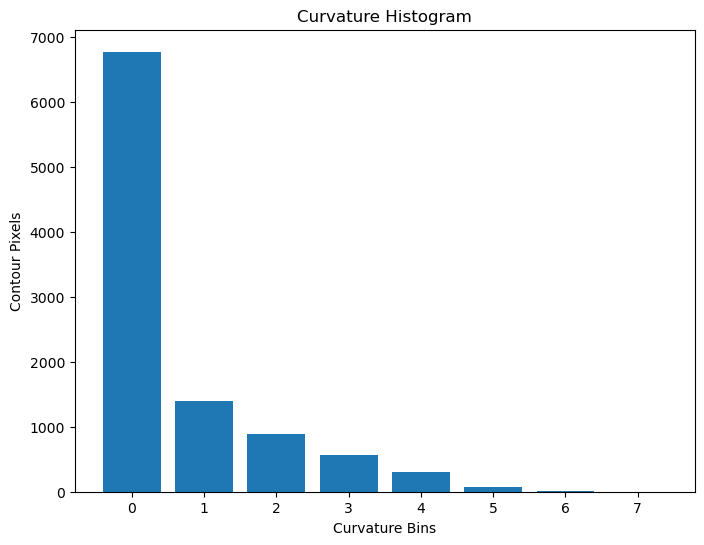

In [35]:
# Plot histogram of cute['normSumCurvatureHistogram'] using plot
plt.figure(figsize=(8,6))
plt.bar(range(len(cute['normSumCurvatureHistogram'])), cute['normSumCurvatureHistogram'])
plt.title('Curvature Histogram')
plt.xlabel('Curvature Bins')
plt.ylabel('Contour Pixels')
plt.show()

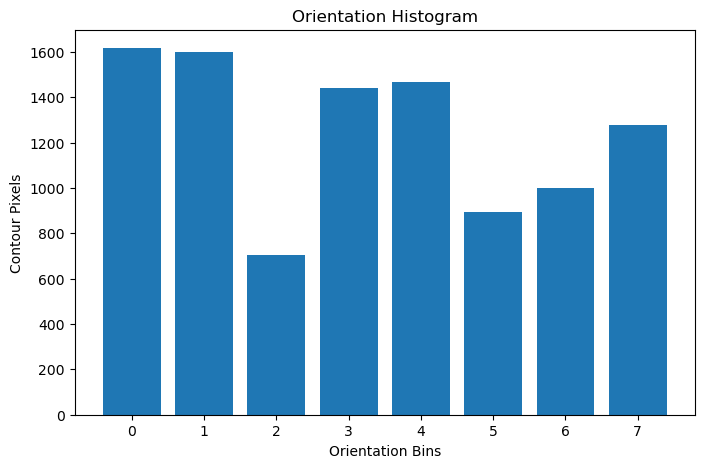

In [36]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normSumOrientationHistogram'])), cute['normSumOrientationHistogram'])
plt.title('Orientation Histogram')
plt.xlabel('Orientation Bins')
plt.ylabel('Contour Pixels')
plt.show()

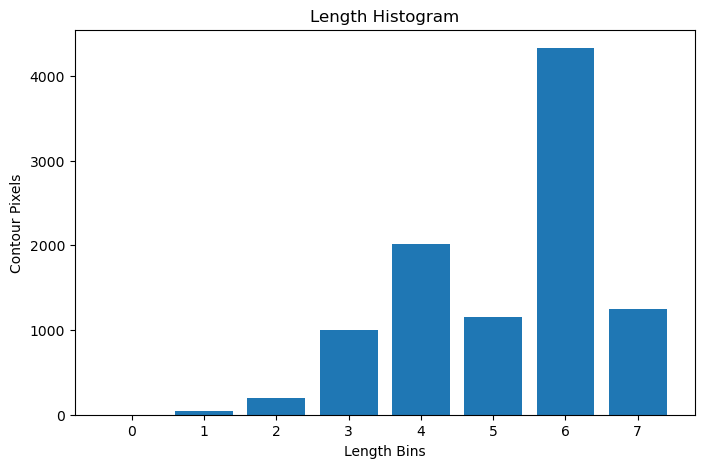

In [37]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normSumLengthHistogram'])), cute['normSumLengthHistogram'])
plt.title('Length Histogram')
plt.xlabel('Length Bins')
plt.ylabel('Contour Pixels')
plt.show()

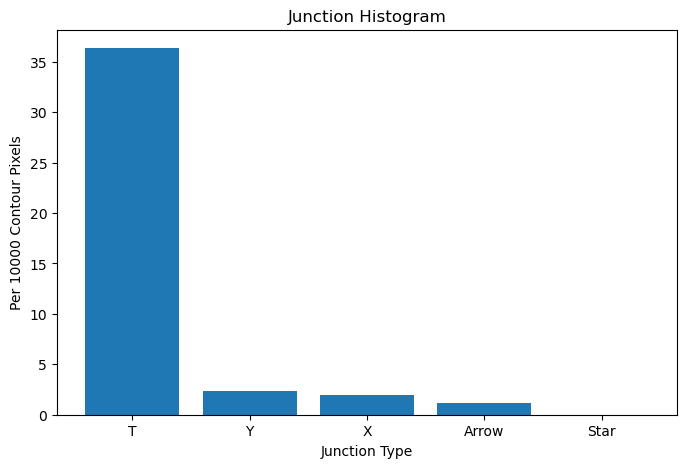

In [38]:
plt.figure(figsize=(8,5))
plt.bar(range(len(cute['normJunctionTypeHistogram'])), cute['normJunctionTypeHistogram'])
plt.title('Junction Histogram')
plt.xlabel('Junction Type')
plt.xticks(range(len(cute['junctionTypeBins'])), cute['junctionTypeBins'])
plt.ylabel('Per 10000 Contour Pixels')
plt.show()